**Set up notebook:**

In [1]:
import sys
sys.path.append('../')
sys.path.append('../library/')
sys.path.append('../library/LogPai/')
sys.path.append('../Dataset/')

In [2]:
#@title Import required libraries for this notebook
from library.malib import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

In [3]:
data_folder = '~/MA/Dataset/'

**Data preprocessing...**

**Load dataset:**

In [49]:
#Read WTG data
signals_train = 'wind-farm-1-signals-training.csv'
signals_test = 'wind-farm-1-signals-testing.csv'
all_data = load_data(data_folder=data_folder, file_name_1=signals_train, file_name_2=signals_test, time_index_column='Timestamp', delimeter=';')

#Read log data
logs_2016 = 'wind-farm-1-logs-2016.csv'
logs_2017 = 'wind-farm-1-logs-2017.csv'
log_data = load_data(data_folder=data_folder, file_name_1=logs_2016, file_name_2=logs_2017, time_index_column='TimeDetected', delimeter=';')
log_data = log_data.loc[log_data.index.notnull()]

#Target/Test turbine: Filter T_09 data out
T09_data = all_data[all_data.Turbine_ID == 'T09']
log_data_T09 = log_data[log_data['UnitTitle'] == 'T09']

#Reference/Validation turbine: Filter T_01 data out
T01_data = all_data[all_data.Turbine_ID == 'T01']
log_data_T01 = log_data[log_data['UnitTitle'] == 'T01']

#Remove duplicates in Timestamp index: Usually occurs at daylight saving
T09_data = T09_data[~T09_data.index.duplicated(keep='first')]
T01_data = T01_data[~T01_data.index.duplicated(keep='first')]

In [5]:
feats = log_data_T01[log_data_T01['Remark'].str.contains('vent\.', case=False, na=False)]['Remark']

**Extract log feature manually:**

In [6]:
feat_names_T01, log_feat_T01 = get_log_features(log_data_T01, 'Remark', 'vent\.')
feat_names_T09, log_feat_T09 = get_log_features(log_data_T09, 'Remark', 'vent\.')

/Users/backupuser/MA/Notebooks/../library/malib.py:259: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  feats = feats[log_msg_column].str.rsplit('.', 1, expand=True).rename(columns = {0 : 'name', 1 : 'value'})
/Users/backupuser/MA/Notebooks/../library/malib.py:259: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  feats = feats[log_msg_column].str.rsplit('.', 1, expand=True).rename(columns = {0 : 'name', 1 : 'value'})


In [7]:
#TODO: check hub fan messages
feat_names, log_feat = get_log_features(log_data_T01, 'Remark', 'vent\.')

/Users/backupuser/MA/Notebooks/../library/malib.py:259: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  feats = feats[log_msg_column].str.rsplit('.', 1, expand=True).rename(columns = {0 : 'name', 1 : 'value'})


In [8]:
for feat in feat_names_T09:
    series = log_feat_T09[feat].dropna().index
    print('Feature: "{}" appeared {} times with {} min, {} mean, and {} max frequency'.format(
        feat, series.shape[0], abs(np.diff(series)).min(), abs(np.diff(series)).mean(), abs(np.diff(series)).max()))
    

Feature: "Gen. ext. vent" appeared 2026 times with 0 days 00:00:01 min, 0 days 08:39:28.683950617 mean, and 9 days 00:41:00 max frequency
Feature: "Gen. int. vent" appeared 1735 times with 0 days 00:00:01 min, 0 days 10:06:27.940023068 mean, and 9 days 00:40:49 max frequency
Feature: "HV Trafo. vent" appeared 329 times with 0 days 00:00:05 min, 2 days 05:03:18.219512195 mean, and 23 days 21:09:58 max frequency
Feature: "Nac.vent" appeared 4586 times with 0 days 00:00:01 min, 0 days 03:48:54.972737186 mean, and 7 days 08:58:01 max frequency


In [9]:
hot_gen = log_data_T09[log_data_T09.Remark.str.contains('Hot generator', case=False, na=False)][['Remark']]
hot_gen.name = 'Hot_Gen'
high_gen = log_data_T09[log_data_T09.Remark.str.contains('High temp. Gen bearing 1', case=False, na=False)][['Remark']]
high_gen.name = 'High Gen'

In [10]:
for feat in [hot_gen, high_gen]:
    series = feat.index
    print('Feature: "{}" appeared {} times with {} min, {} mean, and {} max frequency'.format(
        feat.name, series.shape[0], abs(np.diff(series)).min(), abs(np.diff(series)).mean(), abs(np.diff(series)).max()))

Feature: "Hot_Gen" appeared 899 times with 0 days 00:00:02 min, 0 days 10:27:18.650334075 mean, and 281 days 01:56:53 max frequency
Feature: "High Gen" appeared 31 times with 0 days 01:13:00 min, 3 days 19:16:05.933333333 mean, and 25 days 00:02:52 max frequency


In [11]:
pd.set_option('display.max_rows', 10)
display(high_gen)
pd.set_option('display.max_rows', 200)

,Remark
TimeDetected,
2016-06-07 16:58:42+00:00,High temp. Gen bearing 1: 99°C
2016-06-21 14:45:57+00:00,High temp. Gen bearing 1: 99°C
2016-06-21 16:20:39+00:00,High temp. Gen bearing 1: 99°C
2016-06-21 17:58:34+00:00,High temp. Gen bearing 1: 99°C
2016-06-22 15:01:24+00:00,High temp. Gen bearing 1: 99°C
...,...
2016-09-01 14:01:58+00:00,High temp. Gen bearing 1: 99°C
2016-09-03 15:02:04+00:00,High temp. Gen bearing 1: 99°C
2016-09-28 15:04:56+00:00,High temp. Gen bearing 1: 99°C


In [12]:
def func(df, minutes=10):
      if df.size == 0: return
      timestep = 60 * minutes
      indexes = df.index - (df.index[-1] - pd.Timedelta(seconds=timestep))
      seconds = indexes.seconds
      weight = [seconds[n]/timestep if n == 0 else (seconds[n] - seconds[n - 1])/timestep
            for n, k in enumerate(seconds)]
      return np.sum(weight*df.values)

In [13]:
resampled = log_feat_T01.resample('10T').apply(func)

In [14]:
#resampled.dropna(how='all', inplace=True)
rsm = resampled[((resampled['Nac.vent'] > 0) & (resampled['Nac.vent'] < 1)) | ((resampled['Nac.vent'] > 1) & (resampled['Nac.vent'] < 2))]['Nac.vent']

In [15]:
resampled['Nac.vent'][~resampled['Nac.vent'].isin(log_feat_T01['Nac.vent'].values)]

TimeDetected
2016-01-20 13:40:00+00:00    1.001667
2016-01-22 16:20:00+00:00    1.001667
2016-02-01 17:10:00+00:00    1.001667
2016-02-02 13:50:00+00:00    1.001667
2016-02-24 18:30:00+00:00    1.001667
                               ...   
2017-11-26 14:10:00+00:00    0.998333
2017-11-26 14:20:00+00:00    1.000000
2017-11-26 14:30:00+00:00    1.001667
2017-12-13 09:20:00+00:00    0.780000
2017-12-16 11:50:00+00:00    0.516667
Name: Nac.vent, Length: 2065, dtype: float64

In [16]:
dic = {0.0 : 1.0, 1.0 : 0.0, 2.0 : 1.0}

In [17]:
log_feat_T01['Nac.vent'].values

array([ 2., nan,  1., ...,  1., nan, nan])

In [18]:
#log_feat_T01['Nac.vent'].resample('10T').last().fillna(method='ffill').fillna(method='bfill').fillna(dic[log_feat_T01['Nac.vent'].notnull().iloc[0]])
lgg = log_feat_T01['Nac.vent'].resample('10T').last().fillna(method='ffill')
lgg.loc[rsm.index] = rsm

In [19]:
feat = 'Gen. int. vent'
lgd = log_feat_T01[[feat]].dropna().reset_index()
lgd['diff'] = np.concatenate([[datetime.timedelta(days=100)], abs(np.diff(lgd['TimeDetected']))])
print(lgd.shape[0])
lgd.rename(columns={'Gen. int. vent' : 'Generator internal '})
#lgd[(lgd['diff'] < datetime.timedelta(minutes=10)) | (lgd['diff'].shift(-1) < datetime.timedelta(minutes=10))]

1911


name,TimeDetected,Generator internal,diff
0,2016-01-01 04:09:37+00:00,0.0,100 days 00:00:00
1,2016-01-01 06:54:59+00:00,1.0,0 days 02:45:22
2,2016-01-01 13:49:53+00:00,2.0,0 days 06:54:54
3,2016-01-02 07:09:32+00:00,1.0,0 days 17:19:39
4,2016-01-02 08:56:11+00:00,0.0,0 days 01:46:39
...,...,...,...
1906,2017-12-30 21:38:45+00:00,0.0,0 days 02:08:57
1907,2017-12-31 12:15:36+00:00,1.0,0 days 14:36:51
1908,2017-12-31 13:07:17+00:00,0.0,0 days 00:51:41
1909,2017-12-31 13:11:06+00:00,1.0,0 days 00:03:49


**Extract log feature automatically using logpai:**

In [50]:
#logpai-parsed log features
input_dir  = '~/MA/library/LogPai/logparser/logs/SCADA/' # The input directory of log file
output_dir = input_dir # The output directory of parsing results
log_file   = 'logs_modified.txt' # The input log file name
log_format = '<TimeDetected>;<TimeReset>;<UnitTitle>;<Content>;<UnitTitleDestination>' # SCADA log format

logpai_feats_events_T01 = get_log_pai_feats('T01', 'EventId', data_folder_input=input_dir, data_folder_output=output_dir, 
log_file_name=log_file, log_format=log_format)
logpai_feats_parameters_T01 = get_log_pai_feats('T01', 'ParameterList', data_folder_input=input_dir, data_folder_output=output_dir, 
log_file_name=log_file, log_format=log_format)

logpai_feats_events_T09 = get_log_pai_feats('T09', 'EventId', data_folder_input=input_dir, data_folder_output=output_dir, 
log_file_name=log_file, log_format=log_format)
logpai_feats_parameters_T09 = get_log_pai_feats('T09', 'ParameterList', data_folder_input=input_dir, data_folder_output=output_dir, 
log_file_name=log_file, log_format=log_format)

/Users/backupuser/MA/Notebooks/../library/malib.py:327: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(data_folder + file_name_1, delimiter=delimeter)


====== Transformed train data summary ======
Train data shape: 51479-by-16



/Users/backupuser/MA/Notebooks/../library/malib.py:327: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(data_folder + file_name_1, delimiter=delimeter)


====== Transformed train data summary ======
Train data shape: 51479-by-54



/Users/backupuser/MA/Notebooks/../library/malib.py:327: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(data_folder + file_name_1, delimiter=delimeter)


====== Transformed train data summary ======
Train data shape: 34830-by-16



/Users/backupuser/MA/Notebooks/../library/malib.py:327: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(data_folder + file_name_1, delimiter=delimeter)


====== Transformed train data summary ======
Train data shape: 34830-by-59



In [51]:
logpai_feats_T01 = logpai_feats_events_T01.columns.to_list() + logpai_feats_parameters_T01.columns.to_list()
logpai_feats_T09 = logpai_feats_events_T09.columns.to_list() + logpai_feats_parameters_T09.columns.to_list()

In [37]:
#Custom function to generate time-based weighted averages when aggregating
#time-series data after resampling
def func(df, minutes=10):
    if df.size == 0: return
    timestep = 60 * minutes
    indexes = df.index - (df.index[-1] - pd.Timedelta(seconds=timestep))
    seconds = indexes.seconds
    weight = [seconds[n]/timestep if n == 0 else (seconds[n] - seconds[n - 1])/timestep
        for n, k in enumerate(seconds)]
    return np.sum(weight*df.values)

In [22]:
def time_based_merge(T_data, log_data, columns):
  dic = {0.0 : 1.0, 1.0 : 0.0, 2.0 : 1.0, 3.0 : 2.0} #Needed for ffill after mege

  #Time-Based Weighted-Averaged Log Data
  tbwa_log_data = log_data.resample('10T').apply(func)
  log_data = log_data.resample('10T').last().fillna(method='ffill')

  for column in columns:
    #Get transitional values (!= 0, 1, 2, 3) generated as a result of func
    transitional_values = tbwa_log_data[column][~tbwa_log_data[column].isin(log_data[column].values)]
    log_data[column].loc[transitional_values.index] = transitional_values

    #Just in case the last value was not an integer, this will mess up the ffill algorithm
    log_data[column].iloc[-1] = np.ceil(log_data[column].iloc[-1])

    #Merge signals dataset with log data, fill gaps on the front based on the value from the first occuring non-null values
    T_data = pd.merge_asof(T_data, log_data[column], left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(dic[log_data[column].notnull().iloc[0]])
  
  return T_data


In [206]:
def get_number_of_features(x, min_var=1.0):
    sum = 0.0
    i = 0
    while sum < min_var:
        sum+=x[i]
        i+=1
    return i

In [209]:
def get_projected_data(x, min_var=0.95):
    from sklearn.decomposition import PCA

    pca = PCA()
    pca.fit(x)
    n_features = get_number_of_features(pca.explained_variance_ratio_, min_var)

    pca = PCA(n_components=n_features)
    df = pd.DataFrame(pca.fit_transform(x))
    df.columns = x.columns[: n_features]
    df.index = x.index

    return df.sort_index()

**Append log features to signals:**

In [52]:
#Manual logs
T01_data_logs = time_based_merge(T01_data, log_feat_T01, feat_names_T01)
T09_data_logs = time_based_merge(T09_data, log_feat_T09, feat_names_T09)

In [75]:
#LogPai logs
# T01_logpai_logs_resampled = pd.concat(
#     [
#         logpai_feats_events_T01.resample('10T').apply(func), 
#         logpai_feats_parameters_T01.resample('10T').apply(func)
#         ], 
#         axis=1
#         )
T09_logpai_logs_resampled = pd.concat(
    [
        logpai_feats_events_T09.resample('10T').apply(func).fillna(method='ffill').fillna(method='backfill'), 
        logpai_feats_parameters_T09.resample('10T').apply(func).fillna(method='ffill').fillna(method='backfill')
        ], 
        axis=1
        )

#T01_data_logs = pd.merge_asof(T01_data_logs, T01_logpai_logs_resampled, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='backfill')
T09_data_logs = pd.merge_asof(T09_data_logs, T09_logpai_logs_resampled, left_index = True, right_index = True, tolerance = pd.Timedelta('10m'))

In [217]:
# #LogPai logs
# logpai_feats_T01 = pd.concat([get_projected_data(logpai_feats_events_T01), get_projected_data(logpai_feats_parameters_T01)], axis=1)
# T01_data_logs = pd.merge_asof(T01_data_logs, logpai_feats_T01, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill')

# logpai_feats_T09 = pd.concat([get_projected_data(logpai_feats_events_T09), get_projected_data(logpai_feats_parameters_T09)], axis=1)
# T09_data_logs = pd.merge_asof(T09_data_logs, logpai_feats_T09, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill')

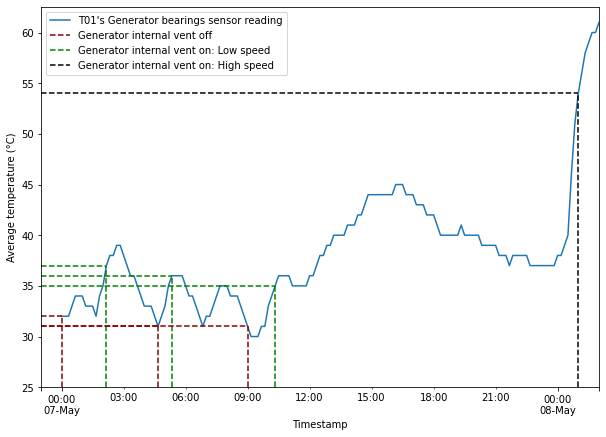

In [19]:
data = T01_data_logs['2016-05-07' : '2016-05-08T02:00:00']
axes = data.plot(y=['Gen_Bear_Temp_Avg'], figsize=(10,7), label=['T01\'s Generator bearings sensor reading'])

last_value = -1
log_feature_name = 'Gen. int. vent'
sensor_feature = 'Gen_Bear_Temp_Avg'
min_y = data[sensor_feature].min() - 5
min_x = data.index[0] - datetime.timedelta(hours = 1)

axes.set_ylim(min_y)
axes.set_xlim(min_x)


for ix, row in data.iterrows():

    if row[log_feature_name] != last_value:
        if row[log_feature_name] == 0.0:
            plt.vlines(x=ix, ymin=min_y, ymax=data.loc[ix, sensor_feature], linestyle='--', color='darkred', label='Generator internal vent off')
            plt.hlines(y=data.loc[ix, sensor_feature], xmin=min_x, xmax=ix, linestyle='--', color='darkred', label='Generator internal vent off')
        elif row[log_feature_name] == 1:
            plt.vlines(x=ix, ymin=min_y, ymax=data.loc[ix, sensor_feature], linestyle='--', color='green', label='Generator internal vent on: Low speed')
            plt.hlines(y=data.loc[ix, sensor_feature], xmin=min_x, xmax=ix, linestyle='--', color='green', label='Generator internal vent on: Low speed')
        elif row[log_feature_name] == 2:
            plt.vlines(x=ix, ymin=min_y, ymax=data.loc[ix, sensor_feature], linestyle='--', color='black', label='Generator internal vent on: High speed')
            plt.hlines(y=data.loc[ix, sensor_feature], xmin=min_x, xmax=ix, linestyle='--', color='black', label='Generator internal vent on: High speed')
        
        last_value=row[log_feature_name]
#plt.xticks(data.index);

plt.ylabel('Average temperature (°C)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

In [20]:
#Run/Stop state logs
#Extract log feature
state_log_feat_T01 = log_data_T01[(log_data_T01.Remark == 'Run') | 
                            (log_data_T01.Remark.str.contains('(Stop|Pause).*kW.*RPM', case=False, na=False)) | 
                            (log_data_T01.Remark.str.contains('new SERVICE state', case=False, na=False))
                            ].Remark
state_log_feat_T01.loc[(state_log_feat_T01 == 'Run') | 
                 (state_log_feat_T01.str.contains('External power ref', case=False, na=False)) | 
                 (state_log_feat_T01.str.contains('new SERVICE state: 1', case=False, na=False))
                 ] = 1
state_log_feat_T01.loc[(state_log_feat_T01.str.contains('(Stop|Pause).*kW.*RPM', case=False, na=False)) | 
                 (state_log_feat_T01.str.contains('new SERVICE state: 0', case=False, na=False))
                 ] = 0

#Append log feature to signals
T01_data_logs = pd.merge_asof(T01_data_logs, state_log_feat_T01, left_index = True, right_index = True).fillna(method='ffill')
T01_data_logs['Remark'] = T01_data_logs['Remark'].fillna(1 - T01_data_logs[T01_data_logs['Remark'].notnull()].iloc[0]['Remark'])

<ipython-input-20-bf8ae66a6a95>:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (log_data_T01.Remark.str.contains('(Stop|Pause).*kW.*RPM', case=False, na=False)) |
<ipython-input-20-bf8ae66a6a95>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_log_feat_T01.loc[(state_log_feat_T01 == 'Run') |
<ipython-input-20-bf8ae66a6a95>:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  state_log_feat_T01.loc[(state_log_feat_T01.str.contains('(Stop|Pause).*kW.*RPM', case=False, na=False)) |
<ipython-input-20-bf8ae66a6a95>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

**EDA...**

In [143]:
#Selected features
#target_features = get_target_columns(T01_data_logs.columns, ['Gen', 'Temp'])
target_features = ['Gen_Bear_Temp_Avg']
#TODO: train on Gearbox temp (w/out log features and with logpai features)
features_wout_logs = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr'] + target_features
features_w_logs = features_wout_logs + feat_names_T01

ser = T01_data_logs[logpai_feats_events_T01.columns].corrwith(T01_data_logs[target_features[0]], method='kendall')
features_w_logs_logpai_T01 = features_wout_logs + list(ser[(ser > 0.3) | (ser < -0.3)].index)

ser = T09_data_logs[logpai_feats_events_T09.columns].corrwith(T09_data_logs[target_features[0]], method='kendall')
features_w_logs_logpai_T09 = features_wout_logs + list(ser[(ser > 0.3) | (ser < -0.3)].index)
target_feature = 'Gen_Bear_Temp_Avg'


#Train/Test Periods
train_start_T09 = '2016-01-01'
train_end_T09 = '2016-02-15'
test_start_T09 = '2016-02-16'
test_end_T09 = '2016-10-18'

train_start_T01 = '2016-09-01'
train_end_T01 = '2017-08-30'
test_start_T01 = '2017-09-01'
test_end_T01 = '2017-12-31'

T09_data_logs.loc[train_start_T09 : train_end_T09, 'dataset'] = 'Train'
T09_data_logs.loc[test_start_T09 : test_end_T09, 'dataset'] = 'Test'

T01_data_logs.loc[train_start_T01 : train_end_T01, 'dataset'] = 'Train'
T01_data_logs.loc[test_start_T01 : test_end_T01, 'dataset'] = 'Test'

In [181]:
T09_data_logs[feat_names_T09].corrwith(T09_data_logs[target_features[0]], method='kendall')

Gen. ext. vent    0.505995
Gen. int. vent    0.656839
HV Trafo. vent    0.500316
Nac.vent          0.480353
dtype: float64

In [141]:
T09_data_logs[logpai_feats_events_T09.columns].corrwith(T09_data_logs[target_features[0]], method='kendall')

logpai_ft_EventId_1    -0.279547
logpai_ft_EventId_2     0.026935
logpai_ft_EventId_3    -0.320831
logpai_ft_EventId_4     0.019996
logpai_ft_EventId_5    -0.296431
logpai_ft_EventId_6     0.018961
logpai_ft_EventId_7     0.231462
logpai_ft_EventId_8    -0.214312
logpai_ft_EventId_9     0.172929
logpai_ft_EventId_10    0.324340
logpai_ft_EventId_11   -0.131364
logpai_ft_EventId_12   -0.011957
logpai_ft_EventId_13   -0.080340
logpai_ft_EventId_14   -0.158273
logpai_ft_EventId_15   -0.126988
logpai_ft_EventId_16   -0.074183
dtype: float64

In [22]:
# cols = {'Nac_Temp_Avg' : 'Avg Temp in Nacelle (◦C)', 'Amb_Temp_Avg' : 'Avg Ambient Temp (◦C)', 'Gen_Bear_Temp_Avg' : 'Avg Temp in Generator Bearings (◦C)',
# 'Gen_RPM_Avg' : 'Avg Generator RPM', 'Prod_LatestAvg_TotActPwr' : 'Total active power (Wh)'}
# df = T01_data_logs.rename(columns=cols)[cols.values()].head(6).reset_index()
# df['Timestamp'] = df['Timestamp'].astype(str)
# df = pd.concat([df, stats], ignore_index=True)

In [23]:
# stats = T01_data_logs[features_wout_logs].apply([len, np.min, np.mean, np.max, np.std]).reset_index().replace({'amax' : 'Max', 'mean' : 'Mean', 'len' : 'Count', 'amin' : 'Min', 'std': 'STD'}).round(2)
# stats = stats.rename(columns=cols | {'index' : 'Timestamp'})

Distribution of Features (T01)

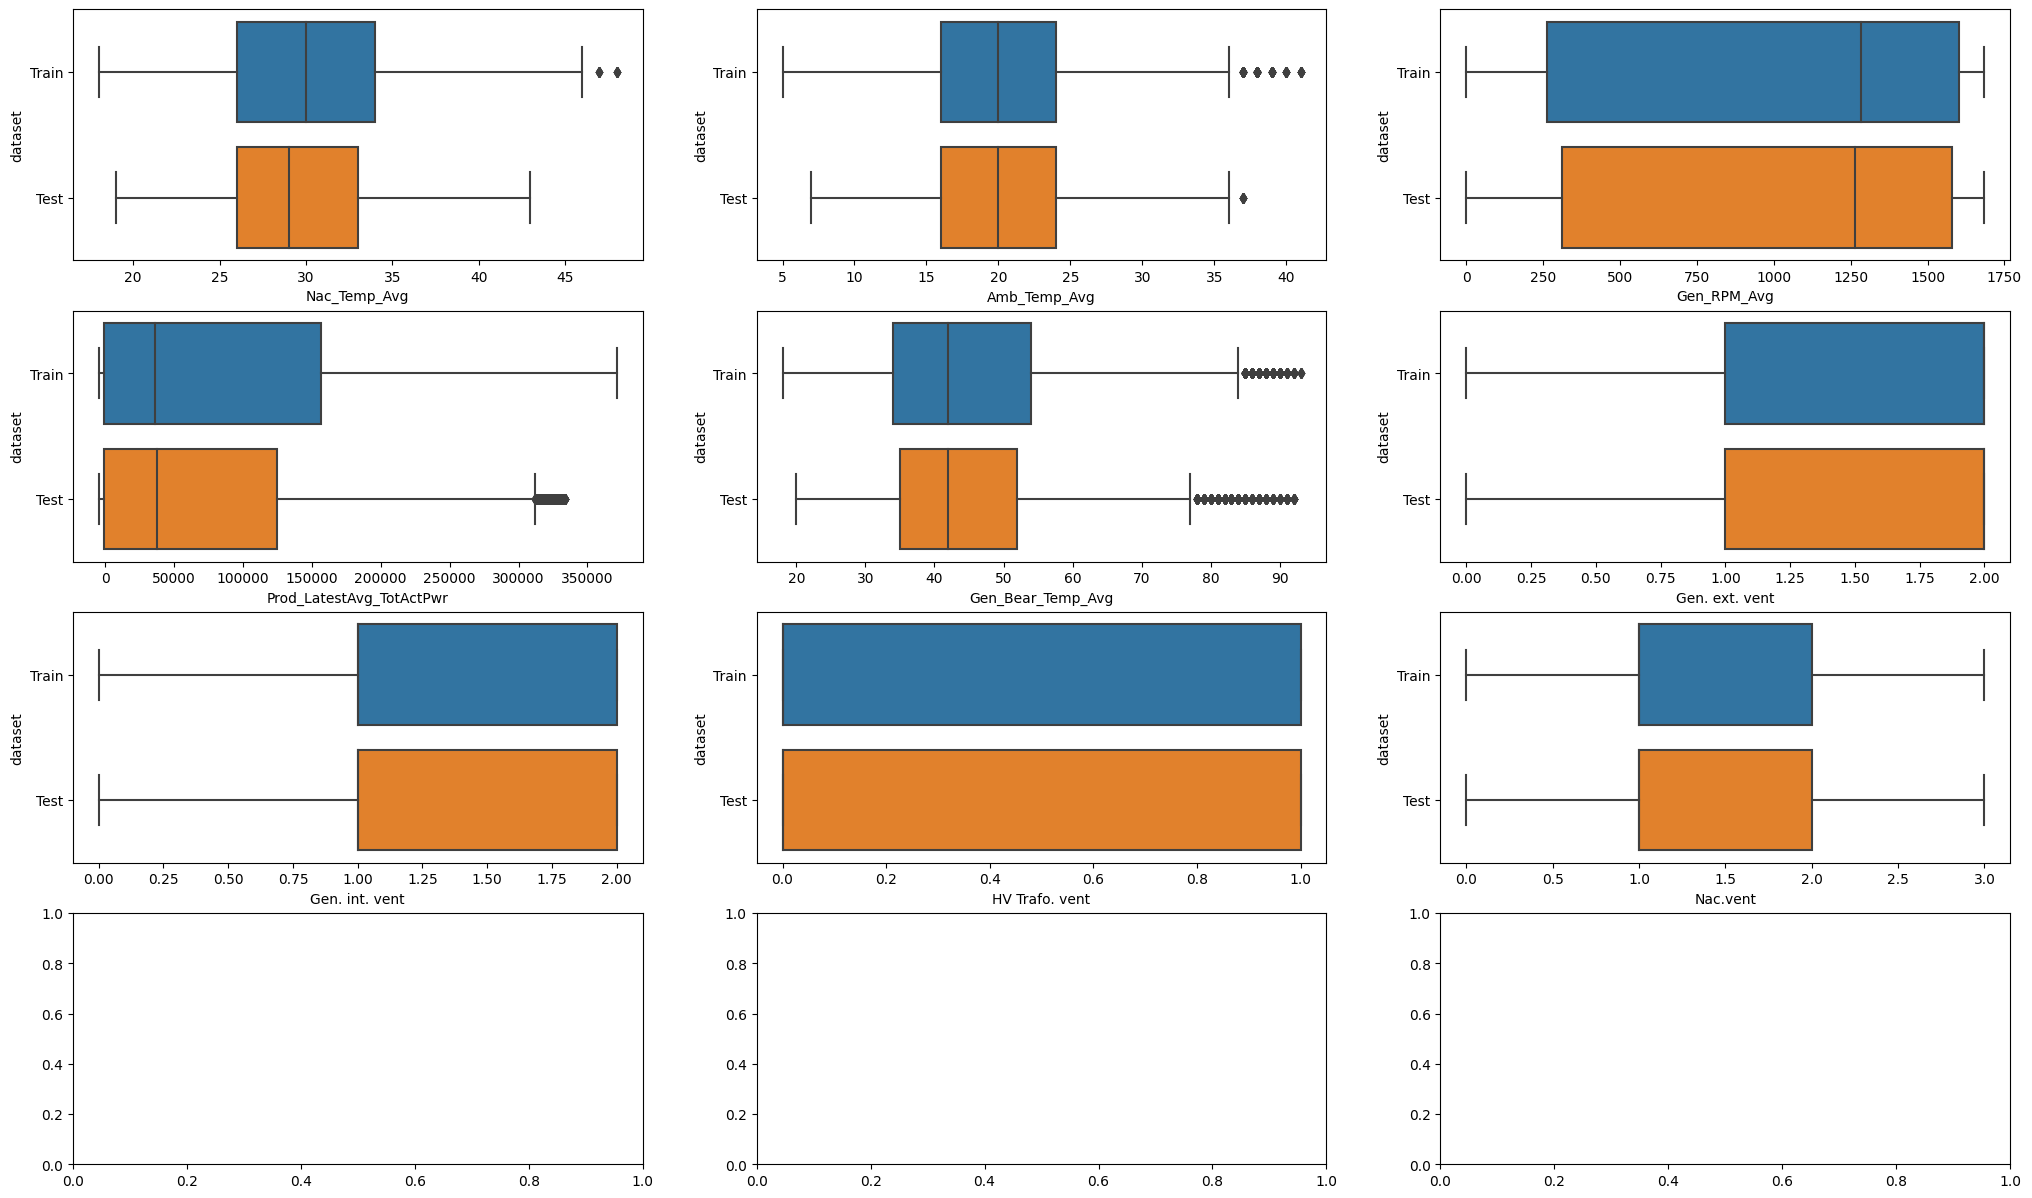

In [45]:
%matplotlib inline
fig, axes = plt.subplots((len(features_w_logs)//3) + 1, 3, figsize=(25,15))
for (i, feature) in zip(range(len(features_w_logs)), features_w_logs):
  sns.boxplot(data = T01_data_logs, x=feature, y='dataset', ax=axes[i//3][i%3])

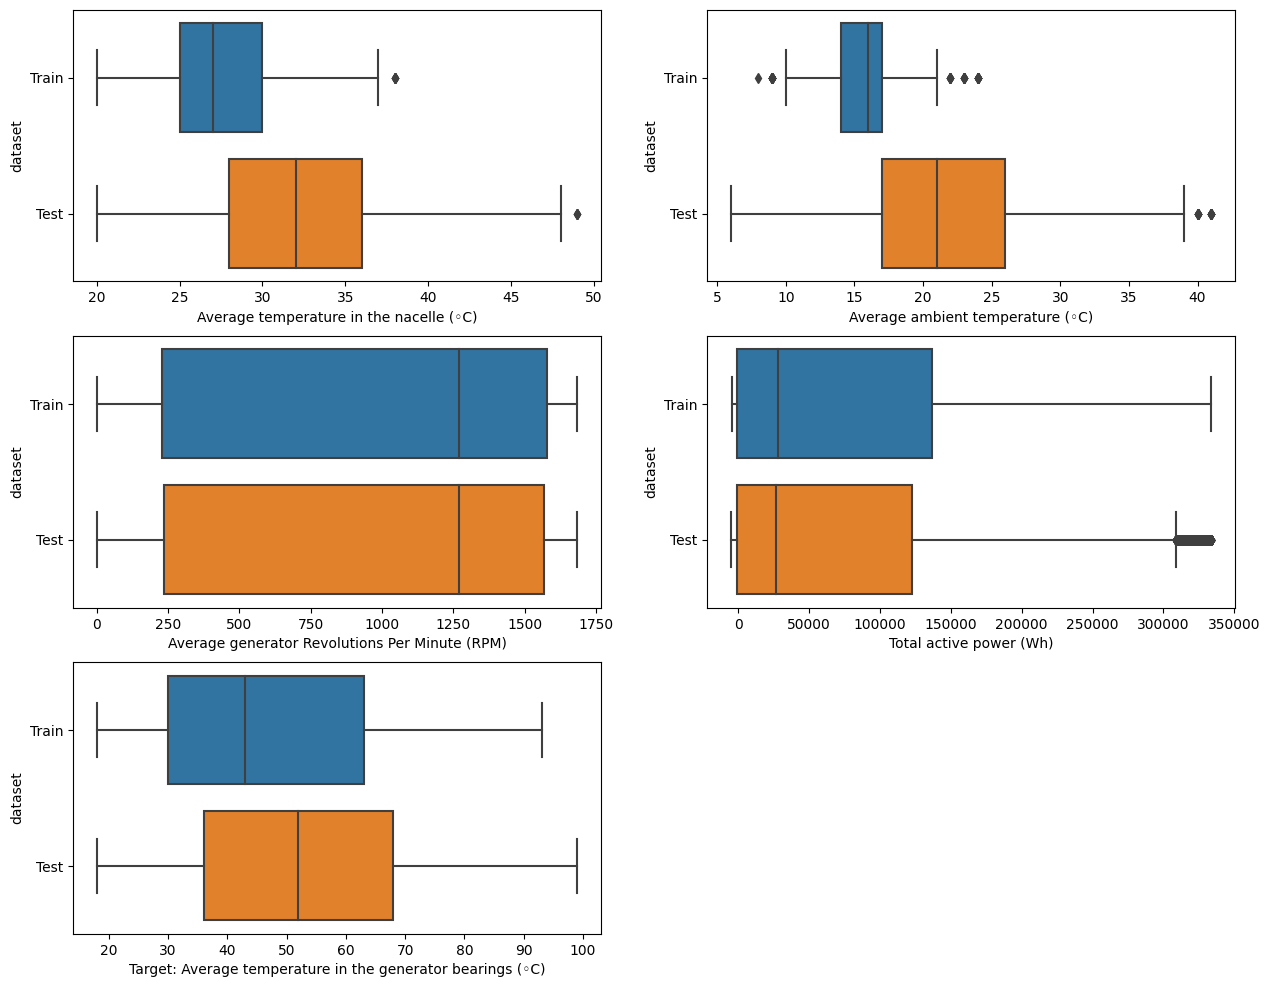

In [180]:
%matplotlib inline
data = T09_data_logs[features_wout_logs + ['dataset']]
col_names = {
    'Nac_Temp_Avg': 'Average temperature in the nacelle (◦C)',
    'Amb_Temp_Avg': 'Average ambient temperature (◦C)',
    'Gen_RPM_Avg': 'Average generator Revolutions Per Minute (RPM)',
    'Prod_LatestAvg_TotActPwr': 'Total active power (Wh)',
    'Gen_Bear_Temp_Avg': 'Target: Average temperature in the generator bearings (◦C)'
    }
data = data.rename(
  columns=col_names)
fig, axes = plt.subplots((len(features_wout_logs)//2) + 1, 2, figsize=(15,12))
for i, feature in enumerate(col_names.values()):
  sns.boxplot(data = data, x=feature, y='dataset', ax=axes[i//2][i%2])

fig.delaxes(axes[2][1])

Correlation of log features with target feature

In [25]:
# dic = [{'turbine' : 'T09', 
#         'Int_Vent' : T09_data_logs[train_start_T09 : train_end_T09][['Int_Vent']].corrwith(T09_data_logs[train_start_T09 : train_end_T09][target_feature])['Int_Vent'],
#         'Ext_Vent' : T09_data_logs[train_start_T09 : train_end_T09][['Ext_Vent']].corrwith(T09_data_logs[train_start_T09 : train_end_T09][target_feature])['Ext_Vent'],
#         'dataset' : 'Train'},
#        {'turbine' : 'T09', 
#         'Int_Vent' : T09_data_logs[test_start_T09 : test_end_T09][['Int_Vent']].corrwith(T09_data_logs[test_start_T09 : test_end_T09][target_feature])['Int_Vent'],
#         'Ext_Vent' : T09_data_logs[test_start_T09 : test_end_T09][['Ext_Vent']].corrwith(T09_data_logs[test_start_T09 : test_end_T09][target_feature])['Ext_Vent'],
#         'dataset' : 'Test'},
#        {'turbine' : 'T01', 
#         'Int_Vent' : T01_data_logs[train_start_T01 : train_end_T01][['Int_Vent']].corrwith(T01_data_logs[train_start_T01 : train_end_T01][target_feature])['Int_Vent'],
#         'Ext_Vent' : T01_data_logs[train_start_T01 : train_end_T01][['Ext_Vent']].corrwith(T01_data_logs[train_start_T01 : train_end_T01][target_feature])['Ext_Vent'],
#         'dataset' : 'Train'},
#        {'turbine' : 'T01', 
#         'Int_Vent' : T01_data_logs[test_start_T01 : test_end_T01][['Int_Vent']].corrwith(T01_data_logs[test_start_T01 : test_end_T01][target_feature])['Int_Vent'],
#         'Ext_Vent' : T01_data_logs[test_start_T01 : test_end_T01][['Ext_Vent']].corrwith(T01_data_logs[test_start_T01 : test_end_T01][target_feature])['Ext_Vent'],
#         'dataset' : 'Test'}]

# corr = pd.DataFrame(dic).set_index('turbine')
# corr

In [26]:
#====================================================================================================================================================

**NBM for T01(Healthy reference turbine)**

In [96]:
T01_data_logs[logpai_feats_events_T01.columns].corrwith(T01_data_logs[target_feature], method='kendall')

logpai_ft_EventId_1    -0.335313
logpai_ft_EventId_2    -0.320031
logpai_ft_EventId_3     0.015902
logpai_ft_EventId_4    -0.220749
logpai_ft_EventId_5     0.083943
logpai_ft_EventId_6    -0.303429
logpai_ft_EventId_7     0.191848
logpai_ft_EventId_8    -0.045460
logpai_ft_EventId_9    -0.077507
logpai_ft_EventId_10   -0.157537
logpai_ft_EventId_11   -0.102636
logpai_ft_EventId_12    0.018344
logpai_ft_EventId_13    0.244219
logpai_ft_EventId_14   -0.129601
logpai_ft_EventId_15    0.361669
logpai_ft_EventId_16   -0.010470
dtype: float64

**Deep Learning**

In [77]:
#Train with log features (Manually-created logs) (single o/p)
dataset_1_s, X_train_1_s, Y_train_1_s, predictions_train_1_s, errors_train_1_s, X_test_1_s, Y_test_1_s, predictions_test_1_s, errors_test_1_s, model_1_s, scaler_input, scaler_target, rmse_train_1_s, rmse_test_1_s = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_w_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                90        
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
521/521 - 8s - loss: 0.0169 - 8s/epoch - 16ms/step
Epoch 2/300
521/521 - 7s - loss: 0.0062 - 7s/epoch - 14ms/step
Epoch 3/300
521/521 - 7s - loss: 0.0053 - 7s/epoch - 13ms/step
Epoch 4/300
521/521 - 7s - loss: 0.0049 - 7s/epoch - 13ms/step
Epoch 5/300
521/521 - 7s - loss: 0.0047 - 7s/epoch

In [ ]:
#RMSE Train:  4.165489862795212
#RMSE Test:  5.425763345730799

In [78]:
#(Linear regression)
dataset_1_s_lnr, X_train_1_s_lnr, Y_train_1_s_lnr, predictions_train_1_s_lnr, errors_train_1_s_lnr, X_test_1_s_lnr, Y_test_1_s_lnr, predictions_test_1_s_lnr, errors_test_1_s_lnr, model_1_s_lnr= \
                        implement_pipeline_reg(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs);

Training model...
Evaluating model...
RMSE Train:  5.293063272799112
RMSE Test:  5.798192824656224


In [79]:
#Train without log features (single o/p)
dataset_1_s_x, X_train_1_s_x, Y_train_1_s_x, predictions_train_1_s_x, errors_train_1_s_x, X_test_1_s_x, Y_test_1_s_x, predictions_test_1_s_x, errors_test_1_s_x, model_1_s_x, scaler_input, scaler_target, rmse_train_1_s_x, rmse_test_1_s_x = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                50        
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
521/521 - 3s - loss: 0.0110 - 3s/epoch - 5ms/step
Epoch 2/300
521/521 - 3s - loss: 0.0055 - 3s/epoch - 5ms/step
Epoch 3/300
521/521 - 2s - loss: 0.0054 - 2s/epoch - 5ms/step
Epoch 4/300
521/521 - 3s - loss: 0.0053 - 3s/epoch - 5ms/step
Epoch 5/300
521/521 - 2s - loss: 0.0052 - 2s/epoch - 5

In [ ]:
# RMSE Train:  4.864589568851764
# RMSE Test:  5.783936556831365

In [109]:
#Train with log features (logpai) (single o/p)
dataset_1_pai, X_train_1_pai, Y_train_1_pai, predictions_train_1_pai, errors_train_1_pai, X_test_1_pai, Y_test_1_pai, predictions_test_1_pai, errors_test_1_pai, model_1_pai, scaler_input, scaler_target, rmse_train_1_pai, rmse_test_1_pai = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_w_logs_logpai_T01, epochs=300, normalize=True);

Training model...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 10)                90        
                                                                 
 dense_28 (Dense)            (None, 10)                110       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
521/521 - 4s - loss: 0.0190 - 4s/epoch - 8ms/step
Epoch 2/300
521/521 - 3s - loss: 0.0071 - 3s/epoch - 6ms/step
Epoch 3/300
521/521 - 4s - loss: 0.0060 - 4s/epoch - 7ms/step
Epoch 4/300
521/521 - 3s - loss: 0.0056 - 3s/epoch - 7ms/step
Epoch 5/300
521/521 - 4s - loss: 0.0054 - 4s/epoch - 7

In [ ]:
#RMSE Train:  4.70435906094707; 4.59
#RMSE Test:  5.8644409979522685; 5.58

**NBM For T09 (Faulty turbine)**

In [80]:
#Train without log features (single o/p)
dataset_1_s_x_09, X_train_1_s_x_09, Y_train_1_s_x_09, predictions_train_1_s_x_09, errors_train_1_s_x_09, X_test_1_s_x_09, Y_test_1_s_x_09, predictions_test_1_s_x_09, errors_test_1_s_x_09, model_1_s_x_09, scaler_input_09, scaler_target_09, rmse_train_1_s_x_09, rmse_test_1_s_x_09 = \
                        implement_pipeline_mlp(T09_data_logs, train_date_start = train_start_T09, train_date_end = train_end_T09,
                                           test_date_start = test_start_T09, test_date_end = test_end_T09, y_column = target_features, turbine_id='T09',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                50        
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
67/67 - 1s - loss: 0.0418 - 599ms/epoch - 9ms/step
Epoch 2/300
67/67 - 0s - loss: 0.0198 - 283ms/epoch - 4ms/step
Epoch 3/300
67/67 - 0s - loss: 0.0171 - 364ms/epoch - 5ms/step
Epoch 4/300
67/67 - 0s - loss: 0.0159 - 286ms/epoch - 4ms/step
Epoch 5/300
67/67 - 0s - loss: 0.0153 - 270ms/epoc

In [ ]:
# RMSE Train:  8.56214862806803
# RMSE Test:  9.084087519644163

In [145]:
#Train with log features (logpai) (single o/p)
dataset_1_pai_09, X_train_1_pai_09, Y_train_1_pai_09, predictions_train_1_pai_09, errors_train_1_pai_09, X_test_1_pai_09, Y_test_1_pai_09, predictions_test_1_pai_09, errors_test_1_pai_09, model_1_pai_09, scaler_input_09, scaler_target_09, rmse_train_1_pai_09, rmse_test_1_pai_09 = \
                        implement_pipeline_mlp(T09_data_logs, train_date_start = train_start_T09, train_date_end = train_end_T09,
                                           test_date_start = test_start_T09, test_date_end = test_end_T09, y_column = target_features, turbine_id='T09',
                         features=features_w_logs_logpai_T09, epochs=300, normalize=True);

Training model...
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 10)                70        
                                                                 
 dense_34 (Dense)            (None, 10)                110       
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
67/67 - 1s - loss: 0.0677 - 1s/epoch - 18ms/step
Epoch 2/300
67/67 - 0s - loss: 0.0362 - 429ms/epoch - 6ms/step
Epoch 3/300
67/67 - 0s - loss: 0.0265 - 428ms/epoch - 6ms/step
Epoch 4/300
67/67 - 0s - loss: 0.0230 - 420ms/epoch - 6ms/step
Epoch 5/300
67/67 - 0s - loss: 0.0209 - 400ms/epoch

In [ ]:
# Old LogPAI:
# RMSE Train:  8.689277649797912
# RMSE Test:  9.37998058271351

# New LogPAI:
# RMSE Train:  9.696345732970222
# RMSE Test:  9.637356850375138

In [82]:
#Train with log features (manual) (single o/p)
dataset_1_logs_09, X_train_1_logs_09, Y_train_1_logs_09, predictions_train_1_logs_09, errors_train_1_logs_09, X_test_1_logs_09, Y_test_1_logs_09, predictions_test_1_logs_09, errors_test_1_logs_09, model_1_logs_09, scaler_input_09, scaler_target_09, rmse_train_1_logs_09, rmse_test_1_logs_09 = \
                        implement_pipeline_mlp(T09_data_logs, train_date_start = train_start_T09, train_date_end = train_end_T09,
                                           test_date_start = test_start_T09, test_date_end = test_end_T09, y_column = target_features, turbine_id='T09',
                         features=features_w_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 10)                90        
                                                                 
 dense_22 (Dense)            (None, 10)                110       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
67/67 - 1s - loss: 0.0499 - 554ms/epoch - 8ms/step
Epoch 2/300
67/67 - 0s - loss: 0.0249 - 359ms/epoch - 5ms/step
Epoch 3/300
67/67 - 0s - loss: 0.0207 - 315ms/epoch - 5ms/step
Epoch 4/300
67/67 - 0s - loss: 0.0194 - 282ms/epoch - 4ms/step
Epoch 5/300
67/67 - 0s - loss: 0.0184 - 365ms/epoc

In [ ]:
# Old Logs: (vents always ints)
# RMSE Train:  9.111628112972433
# RMSE Test:  9.377507195660504

#New Logs:
# RMSE Train:  8.081164020222086
# RMSE Test:  8.93628627383765

Distribution of errors

<AxesSubplot: xlabel='Gen_Bear_Temp_Avg', ylabel='Density'>

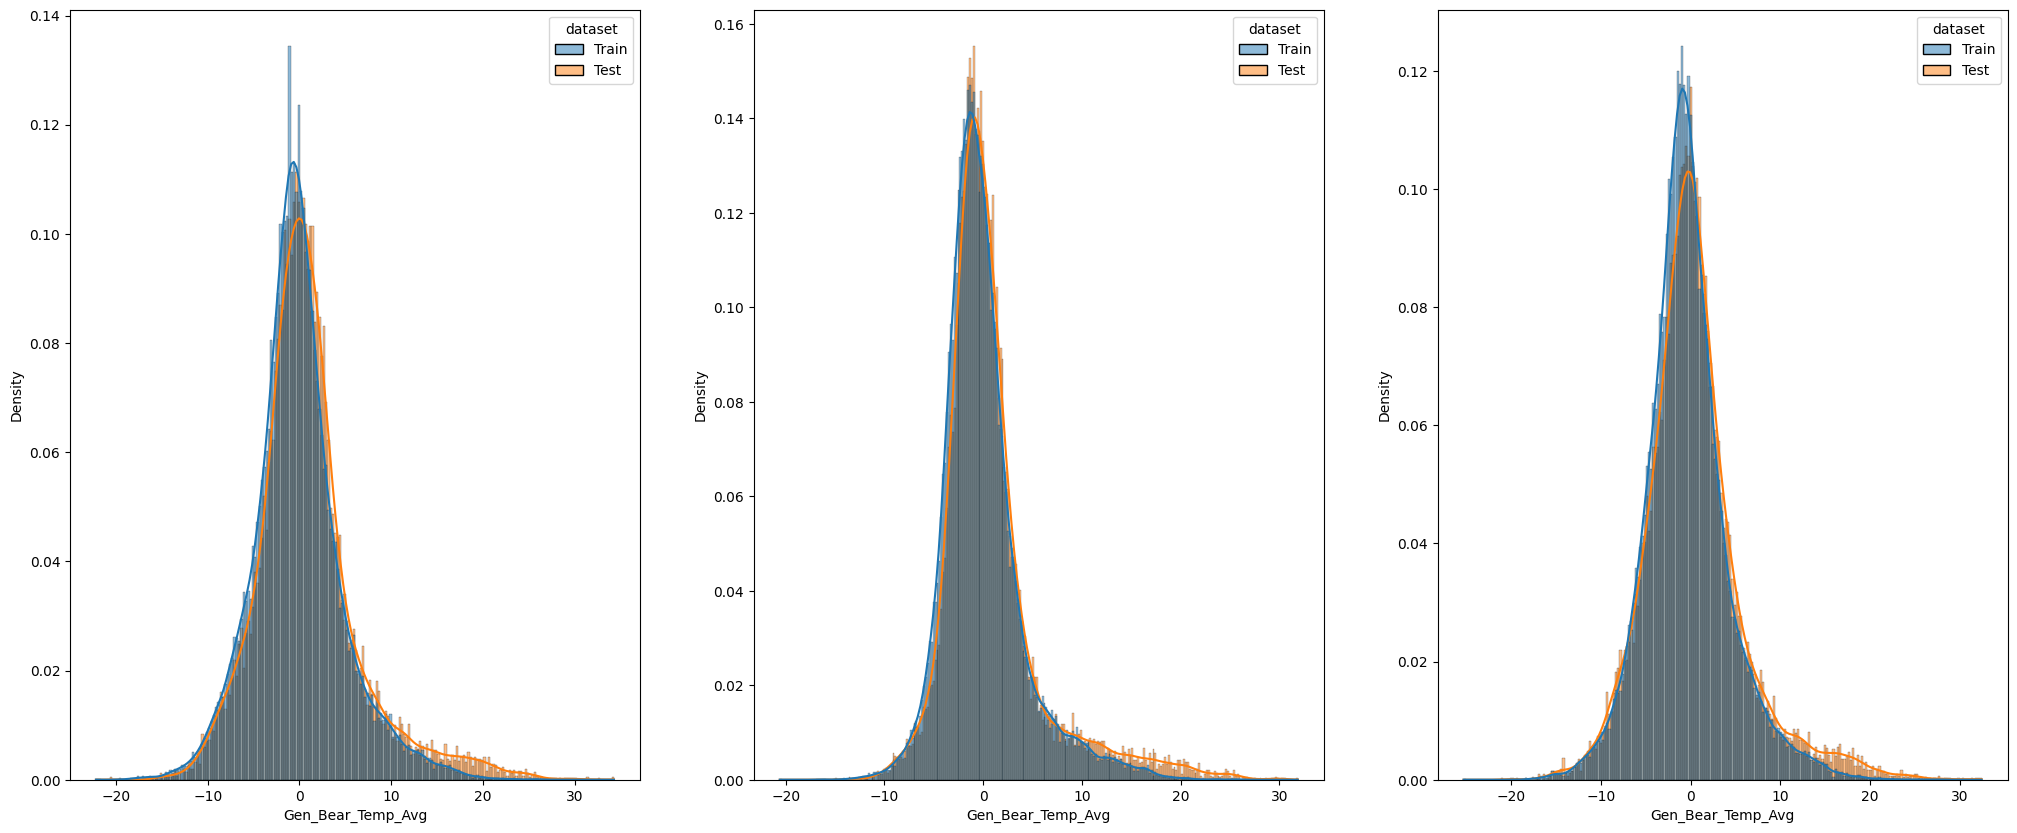

In [312]:
fig, axes = plt.subplots(1, 3, figsize=(25,10))
errors_train_1_s_x['dataset'] = 'Train'
errors_test_1_s_x['dataset'] = 'Test'

errors_train_1_s['dataset'] = 'Train'
errors_test_1_s['dataset'] = 'Test'

errors_train_1_pai['dataset'] = 'Train'
errors_test_1_pai['dataset'] = 'Test'

sns.histplot(pd.concat([errors_train_1_s_x, errors_test_1_s_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_1_s, errors_test_1_s], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])
sns.histplot(pd.concat([errors_train_1_pai, errors_test_1_pai], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[2])

# kl_logs = kl_divergence(np.histogram(errors_train_1_s_x[target_feature[0]], density=True)[0], np.histogram(errors_test_1_s[target_feature[0]], density=True)[0])
# kl_no_logs = kl_divergence(np.histogram(errors_train_1_pai[target_feature[0]], density=True)[0], np.histogram(errors_test_1_pai[target_feature[0]], density=True)[0])

# axes[0].set_title('Histogram of errors (with (manual) logs). KL div.: {}'.format(round(kl_logs, 4)));
# axes[1].set_title('Histogram of errors (with logpai logs). KL div.: {}'.format(round(kl_no_logs, 4)));

In [37]:
# %matplotlib inline
# fig, axes = plt.subplots(len(target_features) + 1, 2, figsize=(25, 10 * (len(target_features) + 1)))
# errors_train_1['dataset'] = 'Train'
# errors_test_1['dataset'] = 'Test'

# errors_train_1_x['dataset'] = 'Train'
# errors_test_1_x['dataset'] = 'Test'

# #Create column to store total error
# errors_train_1['Total_Error'] = errors_train_1.sum(axis=1)
# errors_test_1['Total_Error'] = errors_test_1.sum(axis=1)

# errors_train_1_x['Total_Error'] = errors_train_1_x.sum(axis=1)
# errors_test_1_x['Total_Error'] = errors_test_1_x.sum(axis=1)

# for i, target_feature in enumerate(target_features + ['Total_Error']):

#   sns.histplot(pd.concat([errors_train_1, errors_test_1], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[i][0])
#   sns.histplot(pd.concat([errors_train_1_x, errors_test_1_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[i][1])

#   kl_logs = kl_divergence(np.histogram(errors_train_1[target_feature], density=True)[0], np.histogram(errors_test_1[target_feature], density=True)[0])
#   kl_no_logs = kl_divergence(np.histogram(errors_train_1_x[target_feature], density=True)[0], np.histogram(errors_test_1_x[target_feature], density=True)[0])

#   axes[i][0].set_title('Histogram of errors (with logs). KL div.: {}'.format(round(kl_logs, 4)));
#   axes[i][1].set_title('Histogram of errors (without logs). KL div.: {}'.format(round(kl_no_logs, 4)));

In [38]:
# #Multi vs single output
# fig, axes = plt.subplots(2, 2, figsize=(35,10))

# errors_train_1['model'] = 'Multi o/p'
# errors_test_1['model'] = 'Multi o/p'
# errors_train_1_x['model'] = 'Multi o/p'
# errors_test_1_x['model'] = 'Multi o/p'

# errors_train_1_s['model'] = 'Single o/p'
# errors_test_1_s['model'] = 'Single o/p'
# errors_train_1_s_x['model'] = 'Single o/p'
# errors_test_1_s_x['model'] = 'Single o/p'



# sns.histplot(pd.concat([errors_train_1, errors_train_1_s], ignore_index=True), x=target_feature[0], hue='model', kde=True, stat='density', common_norm=False, ax=axes[0][0])
# sns.histplot(pd.concat([errors_test_1, errors_test_1_s], ignore_index=True), x=target_feature[0], hue='model', kde=True, stat='density', common_norm=False, ax=axes[0][1])

# sns.histplot(pd.concat([errors_train_1_x, errors_train_1_s_x], ignore_index=True), x=target_feature[0], hue='model', kde=True, stat='density', common_norm=False, ax=axes[1][0])
# sns.histplot(pd.concat([errors_test_1_x, errors_test_1_s_x], ignore_index=True), x=target_feature[0], hue='model', kde=True, stat='density', common_norm=False, ax=axes[1][1])

# axes[0][0].set_title('Histogram of train errors (With logs).');
# axes[0][1].set_title('Histogram of test errors (With logs).');
# axes[1][0].set_title('Histogram of train errors (Without logs).');
# axes[1][1].set_title('Histogram of test errors (Without logs).');


Anomaly detection (assuming the error distribution is Gaussian for simplification)

**Healthy Turbine**

In [111]:
anomaly_threshold_x_01_train = errors_train_1_s_x[target_feature].quantile(0.99)
anomaly_threshold_pai_01_train = errors_train_1_pai[target_feature].quantile(0.99)
anomaly_threshold_logs_01_train = errors_train_1_s[target_feature].quantile(0.99)

In [112]:
Y_train_1_s_x['Anomaly'] = errors_train_1_s_x[target_feature] > anomaly_threshold_x_01_train
Y_train_1_pai['Anomaly'] = errors_train_1_pai[target_feature] > anomaly_threshold_pai_01_train
Y_train_1_s['Anomaly'] = errors_train_1_s[target_feature] > anomaly_threshold_logs_01_train

In [120]:
n = 'quantile'
q = 1

n_x_1_train, Y_train_1_s_x = append_alarm_info(Y_train_1_s_x, n=n, q=q)
anomalies_x_1_train = Y_train_1_s_x[Y_train_1_s_x['Anomaly']]

n_pai_1_train, Y_train_1_pai = append_alarm_info(Y_train_1_pai, n=n, q=q)
anomalies_pai_1_train = Y_train_1_pai[Y_train_1_pai['Anomaly']]

n_logs_1_train, Y_train_1_s = append_alarm_info(Y_train_1_s, n=n, q=q)
anomalies_logs_1_train = Y_train_1_s[Y_train_1_s['Anomaly']]

/Users/backupuser/MA/Notebooks/../library/malib.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']


In [121]:
anomaly_threshold_x_01_test = errors_train_1_s_x[target_feature].max()
anomaly_threshold_pai_01_test = errors_train_1_pai[target_feature].max()
anomaly_threshold_logs_01_test = errors_train_1_s[target_feature].max()

In [122]:
Y_test_1_s_x['Anomaly'] = errors_test_1_s_x[target_feature] > anomaly_threshold_x_01_test
Y_test_1_pai['Anomaly'] = errors_test_1_pai[target_feature] > anomaly_threshold_pai_01_test
Y_test_1_s['Anomaly'] = errors_test_1_s[target_feature] > anomaly_threshold_logs_01_test

In [123]:
n_x_1_test, Y_test_1_s_x = append_alarm_info(Y_test_1_s_x, n=n_x_1_train)
anomalies_x_1 = Y_test_1_s_x[Y_test_1_s_x['Anomaly']]

n_pai_1_test, Y_test_1_pai = append_alarm_info(Y_test_1_pai, n=n_pai_1_train)
anomalies_pai_1 = Y_test_1_pai[Y_test_1_pai['Anomaly']]

n_logs_1_test, Y_test_1_s = append_alarm_info(Y_test_1_s, n=n_logs_1_train)
anomalies_logs_1 = Y_test_1_s[Y_test_1_s['Anomaly']]

12


,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm
Timestamp,,,,,


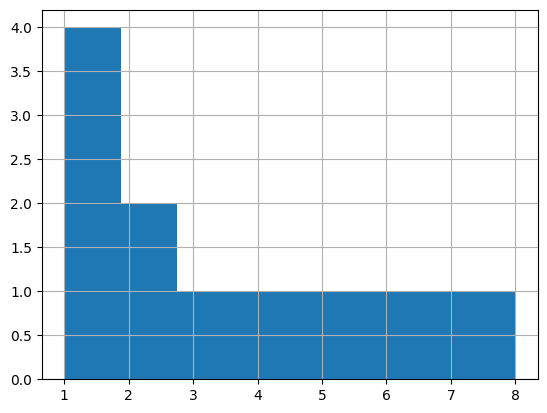

In [124]:
anomalies_x_1['n_Anomaly'].hist(bins=anomalies_x_1['n_Anomaly'].max() - anomalies_x_1['n_Anomaly'].min() + 1)
print(anomalies_x_1.shape[0])
Y_test_1_s_x[Y_test_1_s_x.Alarm]

8


,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm
Timestamp,,,,,


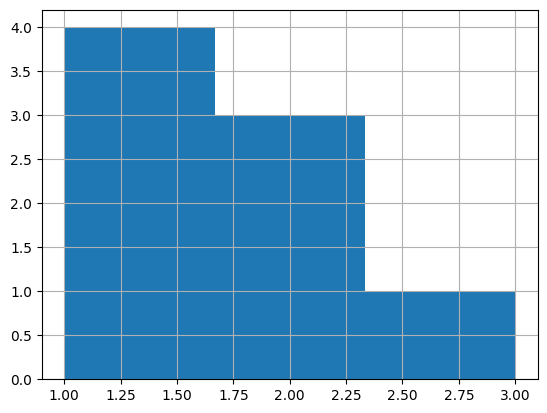

In [125]:
bins = anomalies_pai_1['n_Anomaly'].max() - anomalies_pai_1['n_Anomaly'].min() + 1
anomalies_pai_1['n_Anomaly'].hist(bins= bins if str(bins) != 'nan' else 1)
print(anomalies_pai_1.shape[0])
Y_test_1_pai[Y_test_1_pai.Alarm]

15


,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm
Timestamp,,,,,


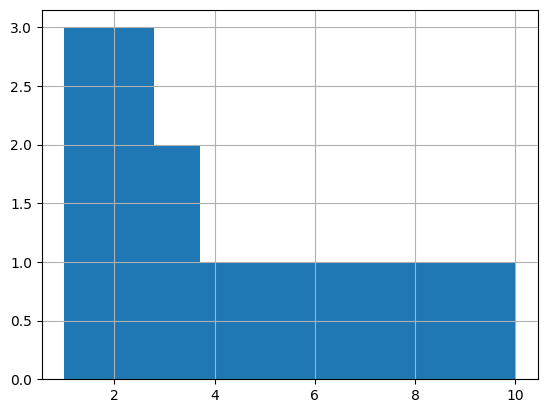

In [126]:
anomalies_logs_1['n_Anomaly'].hist(bins=anomalies_logs_1['n_Anomaly'].max() - anomalies_logs_1['n_Anomaly'].min() + 1)
print(anomalies_logs_1.shape[0])
Y_test_1_s[Y_test_1_s.Alarm]

In [ ]:
# #TODO
# anomalies['Anomaly'].groupby(anomalies.index.day).count().quantile(0.99)

**Faulty Turbine**

In [146]:
anomaly_threshold_x_09_train = errors_train_1_s_x_09[target_feature].quantile(0.99)
anomaly_threshold_pai_09_train = errors_train_1_pai_09[target_feature].quantile(0.99)
anomaly_threshold_logs_09_train = errors_train_1_logs_09[target_feature].quantile(0.99)

In [147]:
Y_train_1_s_x_09['Anomaly'] = errors_train_1_s_x_09[target_feature] > anomaly_threshold_x_09_train
Y_train_1_pai_09['Anomaly'] = errors_train_1_pai_09[target_feature] > anomaly_threshold_pai_09_train
Y_train_1_logs_09['Anomaly'] = errors_train_1_logs_09[target_feature] > anomaly_threshold_logs_09_train

In [148]:
n = 'quantile'
#No alarms should be sent in train period
q = 1

n_x_train, Y_train_1_s_x_09 = append_alarm_info(Y_train_1_s_x_09, n=n, q=q)
anomalies_x_train = Y_train_1_s_x_09[Y_train_1_s_x_09['Anomaly']]

n_pai_train, Y_train_1_pai_09 = append_alarm_info(Y_train_1_pai_09, n=n, q=q)
anomalies_pai_train = Y_train_1_pai_09[Y_train_1_pai_09['Anomaly']]

n_logs_train, Y_train_1_logs_09 = append_alarm_info(Y_train_1_logs_09, n=n, q=q)
anomalies_logs_train = Y_train_1_logs_09[Y_train_1_logs_09['Anomaly']]

/Users/backupuser/MA/Notebooks/../library/malib.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']
/Users/backupuser/MA/Notebooks/../library/malib.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']
/Users/backupuser/MA/Notebooks/../library/malib.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [149]:
anomaly_threshold_x_09_test = errors_train_1_s_x_09[target_feature].max()
anomaly_threshold_pai_09_test = errors_train_1_pai_09[target_feature].max()
anomaly_threshold_logs_09_test = errors_train_1_logs_09[target_feature].max()

In [150]:
Y_test_1_s_x_09['Anomaly'] = errors_test_1_s_x_09[target_feature] > anomaly_threshold_x_09_test
Y_test_1_pai_09['Anomaly'] = errors_test_1_pai_09[target_feature] > anomaly_threshold_pai_09_test
Y_test_1_logs_09['Anomaly'] = errors_test_1_logs_09[target_feature] > anomaly_threshold_logs_09_test

In [151]:
n_x_test, Y_test_1_s_x_09 = append_alarm_info(Y_test_1_s_x_09, n=n_x_train)
anomalies_x = Y_test_1_s_x_09[Y_test_1_s_x_09['Anomaly']]

n_pai_test, Y_test_1_pai_09 = append_alarm_info(Y_test_1_pai_09, n=n_pai_train)
anomalies_pai = Y_test_1_pai_09[Y_test_1_pai_09['Anomaly']]

n_logs_test, Y_test_1_logs_09 = append_alarm_info(Y_test_1_logs_09, n=n_logs_train)
anomalies_logs = Y_test_1_logs_09[Y_test_1_logs_09['Anomaly']]

/Users/backupuser/MA/Notebooks/../library/malib.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']
/Users/backupuser/MA/Notebooks/../library/malib.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']
/Users/backupuser/MA/Notebooks/../library/malib.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [134]:
#Override
def append_relevant_log_warnings(Y: pd.DataFrame, logs: pd.DataFrame, log_msg_column, target_feature_name, filter_by=None, max_distance='24H'):
  component = target_feature_name.split('_')[0]
  relevant_logs = logs[logs[log_msg_column].str.match('((?=.*Hot)(?=.*{}))|((?=.*High temp)(?=.*{}))'.format(component, component), na=False, case=False)]

  Y['logs_found'] = None
  for index, row in Y[Y[filter_by]].iterrows() if filter_by else Y.iterrows():
    filtered_logs = relevant_logs[(index - pd.Timedelta(max_distance)) : index]
    if not filtered_logs.empty:
      string = ''
      for i, r in filtered_logs.iterrows():
        string = string + r[log_msg_column] + ' @ ' + str(i) + '\n '
      Y.loc[index, 'logs_found'] = string

    else:
      Y.loc[index, 'logs_found'] = None
    
  return Y

In [218]:
cols = {
    'Gen_Bear_Temp_Avg': 'Average temperature in the generator bearings (◦C)',
    'n_Anomaly': 'N. of Anomalies found',
    'Alarm': 'Alarm sent?',
    'logs_found': 'Relevant messages found in Alarm & Warning log'
}

In [310]:
c1 = Y_test_1_s_x_09[Y_test_1_s_x_09.Anomaly].resample('1D').last().dropna(how='all')
c1.index = c1.index.map(lambda t: t.replace(hour=23, minute=59, second=59))
c1 = append_relevant_log_warnings(c1, log_data_T09, 'Remark', target_feature)
c1.rename(columns=cols, inplace=True)
c1['Date'] = c1.index.date
c1['Alarm sent?'] = c1['Alarm sent?'].astype(bool)
c1 = c1.reset_index().set_index('Date')[list(cols.values())].replace(True, 'Yes').replace(False, 'No')
print('Number of anomalous days:', c1.shape[0])
print('Correlation with warnings found: ', c1['Relevant messages found in Alarm & Warning log'].dropna().shape[0])
print('Number of anomalies:', c1['N. of Anomalies found'].sum())
c1

Number of anomalous days: 29
Correlation with warnings found:  14
Number of anomalies: 48.0


,Average temperature in the generator bearings (◦C),N. of Anomalies found,Alarm sent?,Relevant messages found in Alarm & Warning log
Date,,,,
2016-02-17,57.0,2.0,No,None
2016-02-20,83.0,2.0,No,None
2016-02-26,83.0,2.0,No,None
2016-03-07,78.0,2.0,No,None
2016-03-08,54.0,2.0,No,None
2016-03-22,70.0,3.0,No,None
2016-03-31,72.0,1.0,No,None
2016-04-06,48.0,3.0,No,None
2016-04-20,65.0,1.0,No,None


In [309]:
c2 = Y_test_1_pai_09[Y_test_1_pai_09.Anomaly].resample('1D').last().dropna(how='all')
c2.index = c2.index.map(lambda t: t.replace(hour=23, minute=59, second=59))
c2 = append_relevant_log_warnings(c2, log_data_T09, 'Remark', target_feature)
c2.rename(columns=cols, inplace=True)
c2['Date'] = c2.index.date
c2['Alarm sent?'] = c3['Alarm sent?'].astype(bool)
c2 = c2.reset_index().set_index('Date')[list(cols.values())].replace(True, 'Yes').replace(False, 'No')
print('Number of anomalous days:', c2.shape[0])
print('Correlation with warnings found: ', c3['Relevant messages found in Alarm & Warning log'].dropna().shape[0])
print('Number of anomalies:', c2['N. of Anomalies found'].sum())
c2

Number of anomalous days: 53
Correlation with warnings found:  18
Number of anomalies: 236.0


,Average temperature in the generator bearings (◦C),N. of Anomalies found,Alarm sent?,Relevant messages found in Alarm & Warning log
Date,,,,
2016-02-16,72.0,5.0,NaN,None
2016-02-17,57.0,2.0,NaN,None
2016-02-18,64.0,1.0,NaN,None
2016-02-20,83.0,2.0,NaN,None
2016-02-26,87.0,1.0,NaN,None
2016-02-27,78.0,1.0,NaN,None
2016-03-07,78.0,2.0,NaN,None
2016-03-08,54.0,6.0,NaN,None
2016-03-22,70.0,3.0,NaN,None


In [308]:
c3 = Y_test_1_logs_09[Y_test_1_logs_09.Anomaly].resample('1D').last().dropna(how='all')
c3.index = c3.index.map(lambda t: t.replace(hour=23, minute=59, second=59))
c3 = append_relevant_log_warnings(c3, log_data_T09, 'Remark', target_feature)
c3.rename(columns=cols, inplace=True)
c3['Date'] = c3.index.date
c3['Alarm sent?'] = c3['Alarm sent?'].astype(bool)
c3 = c3.reset_index().set_index('Date')[list(cols.values())].replace(True, 'Yes').replace(False, 'No')
print('Number of anomalous days:', c3.shape[0])
print('Correlation with warnings found: ', c3['Relevant messages found in Alarm & Warning log'].dropna().shape[0])
print('Number of anomalies:', c3['N. of Anomalies found'].sum())
c3

Number of anomalous days: 42
Correlation with warnings found:  18
Number of anomalies: 217.0


,Average temperature in the generator bearings (◦C),N. of Anomalies found,Alarm sent?,Relevant messages found in Alarm & Warning log
Date,,,,
2016-02-16,72.0,10.0,No,None
2016-02-17,56.0,1.0,No,None
2016-02-18,57.0,1.0,No,None
2016-02-19,70.0,25.0,Yes,None
2016-02-20,90.0,19.0,Yes,None
2016-03-06,49.0,2.0,No,None
2016-03-07,78.0,2.0,No,None
2016-03-08,60.0,7.0,No,None
2016-03-10,54.0,14.0,Yes,None


In [279]:
#Override
def plot_predicted_vs_true(predictions: pd.DataFrame, ground_truth: pd.DataFrame, y_column, hue=None, x_column='index', figsize=(25, 7), xlabel='Timestamp', ylabel=None):

  fig, ax = plt.subplots(figsize=figsize)
  if hue:
    ax.plot(getattr(ground_truth, x_column), ground_truth[y_column], label='Measured signal', color='blue')
    ax.scatter(getattr(ground_truth[ground_truth[hue] == True], x_column), ground_truth[ground_truth[hue] == True][y_column], label='{}'.format(hue), color='darkred', marker='x', s=100)
  else:
    ax.plot(getattr(ground_truth, x_column), ground_truth[y_column], label='Measured signal', color='blue')

  ax.plot(getattr(predictions, x_column), predictions[y_column], label='Simulation', color='green')

  ax.grid(True)

  ax.legend()
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel) if ylabel else ax.set_ylabel(y_column + ' [0C]')

In [253]:
pd.set_option('display.width', 0)
pd.set_option('display.expand_frame_repr', True)

In [294]:
print('---------{}---------'.format('Alarms & Warnings found in the SCADA log'))
for i, row in c3['2016-08-22' : '2016-08-24'].set_index('Date')[['Relevant messages found in Alarm & Warning log']].iterrows():
    print('------------------------{}------------------------'.format(i))
    print(row['Relevant messages found in Alarm & Warning log'])

---------Alarms & Warnings found in the SCADA log---------
------------------------2016-08-22------------------------
Hot generator 146°C      0kW @ 2016-08-22 13:50:21+00:00
 High temp. Gen bearing 1: 99°C @ 2016-08-22 14:15:07+00:00
 High temp. Gen bearing 1: 99°C @ 2016-08-22 18:24:55+00:00
 
------------------------2016-08-23------------------------
High temp. Gen bearing 1: 99°C @ 2016-08-23 13:12:42+00:00
 High temp. Gen bearing 1: 99°C @ 2016-08-23 16:53:19+00:00
 
------------------------2016-08-24------------------------
Hot generator 146°C      0kW @ 2016-08-24 15:16:29+00:00
 Hot generator 145°C      0kW @ 2016-08-24 15:56:55+00:00
 Hot generator 145°C      0kW @ 2016-08-24 15:57:00+00:00
 Hot generator 145°C      0kW @ 2016-08-24 15:57:19+00:00
 Hot generator 145°C      0kW @ 2016-08-24 15:57:21+00:00
 Hot generator 145°C      0kW @ 2016-08-24 15:57:25+00:00
 


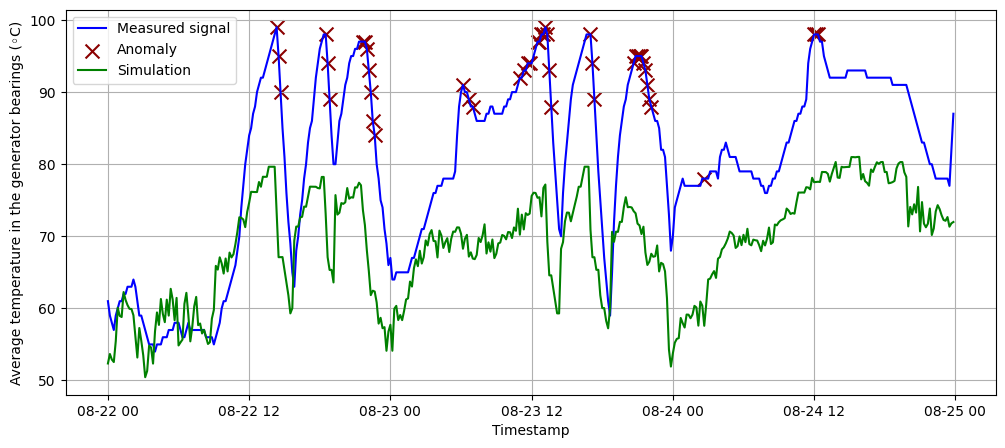

In [283]:
plot_predicted_vs_true(predictions_test_1_logs_09['2016-08-22' : '2016-08-24'], Y_test_1_logs_09['2016-08-22' : '2016-08-24'], target_feature, hue='Anomaly', figsize=(12,5), ylabel='Average temperature in the generator bearings (◦C)')

In [152]:
Y_test_1_s_x_09 = append_relevant_log_warnings(Y_test_1_s_x_09, log_data_T09, 'Remark', target_feature, filter_by='Alarm', max_distance='24H')
Y_test_1_pai_09 = append_relevant_log_warnings(Y_test_1_pai_09, log_data_T09, 'Remark', target_feature, filter_by='Alarm', max_distance='24H')
Y_test_1_logs_09 = append_relevant_log_warnings(Y_test_1_logs_09, log_data_T09, 'Remark', target_feature, filter_by='Alarm', max_distance='24H')

,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm,logs_found
Timestamp,,,,,,


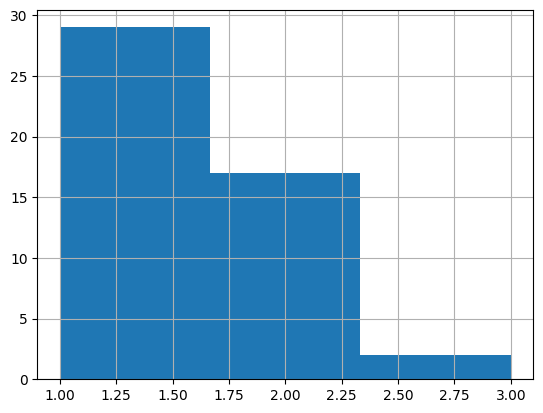

In [153]:
anomalies_x['n_Anomaly'].hist(bins=anomalies_x['n_Anomaly'].max() - anomalies_x['n_Anomaly'].min() + 1)
Y_test_1_s_x_09[Y_test_1_s_x_09.Alarm]

,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm,logs_found
Timestamp,,,,,,


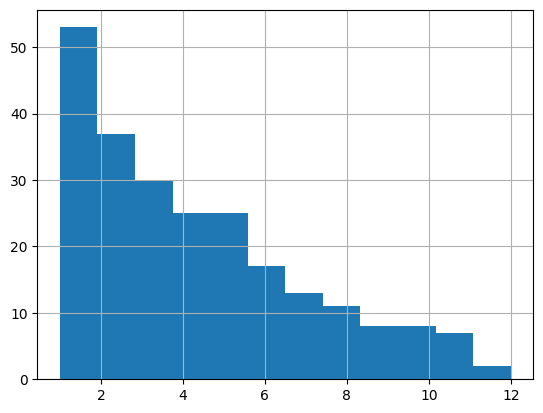

In [154]:
anomalies_pai['n_Anomaly'].hist(bins=anomalies_pai['n_Anomaly'].max() - anomalies_pai['n_Anomaly'].min() + 1)
Y_test_1_pai_09[Y_test_1_pai_09.Alarm]

6 alarms


,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm,logs_found
Timestamp,,,,,,
2016-02-19 00:00:00+00:00,70.0,1.0,0.0,25.0,1.0,None
2016-02-20 00:00:00+00:00,90.0,1.0,0.0,19.0,1.0,None
2016-03-10 00:00:00+00:00,54.0,1.0,0.0,14.0,1.0,None
2016-08-21 00:00:00+00:00,87.0,1.0,0.0,26.0,1.0,None
2016-08-22 00:00:00+00:00,84.0,1.0,0.0,13.0,1.0,Hot generator 146°C 0kW @ 2016-08-22 13:5...
2016-08-23 00:00:00+00:00,88.0,1.0,0.0,28.0,1.0,High temp. Gen bearing 1: 99°C @ 2016-08-23 13...


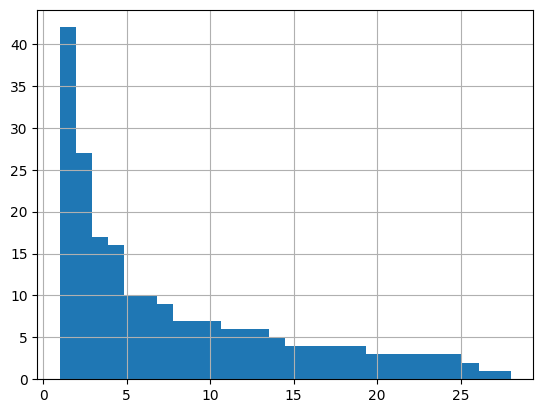

In [155]:
anomalies_logs['n_Anomaly'].hist(bins=anomalies_logs['n_Anomaly'].max() - anomalies_logs['n_Anomaly'].min() + 1)
alarms_df = Y_test_1_logs_09[Y_test_1_logs_09.Alarm]
alarms_df = alarms_df.resample('1D').last().dropna(how='all')
print('{} alarms'.format(alarms_df.shape[0]))
alarms_df

In [163]:
Y_test_1_s_x_09[Y_test_1_s_x_09.Anomaly].resample('1D').last().dropna(how='all')

,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm,logs_found
Timestamp,,,,,,
2016-02-17 00:00:00+00:00,57.0,1.0,0.0,2.0,0.0,None
2016-02-20 00:00:00+00:00,83.0,1.0,0.0,2.0,0.0,None
2016-02-26 00:00:00+00:00,83.0,1.0,0.0,2.0,0.0,None
2016-03-07 00:00:00+00:00,78.0,1.0,0.0,2.0,0.0,None
2016-03-08 00:00:00+00:00,54.0,1.0,0.0,2.0,0.0,None
2016-03-22 00:00:00+00:00,70.0,1.0,0.0,3.0,0.0,None
2016-03-31 00:00:00+00:00,72.0,1.0,0.0,1.0,0.0,None
2016-04-06 00:00:00+00:00,48.0,1.0,0.0,3.0,0.0,None
2016-04-20 00:00:00+00:00,65.0,1.0,0.0,1.0,0.0,None


In [162]:
Y_test_1_pai_09[Y_test_1_pai_09.Anomaly].resample('1D').last().dropna(how='all')

,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm,logs_found
Timestamp,,,,,,
2016-02-16 00:00:00+00:00,72.0,1.0,0.0,5.0,0.0,None
2016-02-17 00:00:00+00:00,57.0,1.0,0.0,2.0,0.0,None
2016-02-18 00:00:00+00:00,64.0,1.0,0.0,1.0,0.0,None
2016-02-20 00:00:00+00:00,83.0,1.0,0.0,2.0,0.0,None
2016-02-26 00:00:00+00:00,87.0,1.0,0.0,1.0,0.0,None
2016-02-27 00:00:00+00:00,78.0,1.0,0.0,1.0,0.0,None
2016-03-07 00:00:00+00:00,78.0,1.0,0.0,2.0,0.0,None
2016-03-08 00:00:00+00:00,54.0,1.0,0.0,6.0,0.0,None
2016-03-22 00:00:00+00:00,70.0,1.0,0.0,3.0,0.0,None


In [161]:
Y_test_1_logs_09[Y_test_1_logs_09.Anomaly].resample('1D').last().dropna(how='all')

,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm,logs_found
Timestamp,,,,,,
2016-02-16 00:00:00+00:00,72.0,1.0,0.0,10.0,0.0,None
2016-02-17 00:00:00+00:00,56.0,1.0,0.0,1.0,0.0,None
2016-02-18 00:00:00+00:00,57.0,1.0,0.0,1.0,0.0,None
2016-02-19 00:00:00+00:00,70.0,1.0,0.0,25.0,1.0,None
2016-02-20 00:00:00+00:00,90.0,1.0,0.0,19.0,1.0,None
2016-03-06 00:00:00+00:00,49.0,1.0,0.0,2.0,0.0,None
2016-03-07 00:00:00+00:00,78.0,1.0,0.0,2.0,0.0,None
2016-03-08 00:00:00+00:00,60.0,1.0,0.0,7.0,0.0,None
2016-03-10 00:00:00+00:00,54.0,1.0,0.0,14.0,1.0,None


In [157]:
alarms_df.index.date

array([datetime.date(2016, 2, 19), datetime.date(2016, 2, 20),
       datetime.date(2016, 3, 10), datetime.date(2016, 8, 21),
       datetime.date(2016, 8, 22), datetime.date(2016, 8, 23)],
      dtype=object)

In [126]:
y, x = np.histogram(anomalies_pai['n_Anomaly'], bins=anomalies_pai['n_Anomaly'].max() - anomalies_pai['n_Anomaly'].min() + 1)

In [127]:
b, a = np.polyfit(x[:-1], np.log(y), 1)

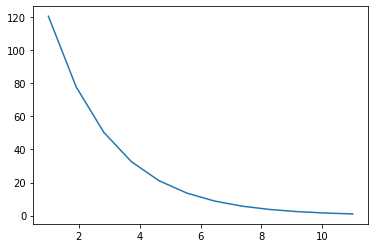

In [128]:
plt.plot(x, np.exp(a) * np.exp(b * x))

In [129]:
anomaly_thresholds_1 = [errors_train_1[target_feature].mean() + 3 * errors_train_1[target_feature].std() for target_feature in target_features]
booleans_train_1 = errors_train_1[target_features] > anomaly_thresholds_1
booleans_test_1 = errors_test_1[target_features] > anomaly_thresholds_1  

anomaly_thresholds_1_x = [errors_train_1_x[target_feature].mean() + 3 * errors_train_1_x[target_feature].std() for target_feature in target_features]
booleans_train_1_x = errors_train_1_x[target_features] > anomaly_thresholds_1_x
booleans_test_1_x = errors_test_1_x[target_features] > anomaly_thresholds_1_x

#System Anomaly if model detected an anomaly for ANY of the target features
Y_test_1['Anomaly_Any'] = booleans_test_1.apply(any, axis=1)
Y_train_1['Anomaly_Any'] = booleans_train_1.apply(any, axis=1)

Y_test_1_x['Anomaly_Any'] = booleans_test_1_x.apply(any, axis=1)
Y_train_1_x['Anomaly_Any'] = booleans_train_1_x.apply(any, axis=1)

#System Anomaly if model detected an anomaly for ALL of the target features
Y_test_1['Anomaly_All'] = booleans_test_1.apply(all, axis=1)
Y_train_1['Anomaly_All'] = booleans_train_1.apply(all, axis=1)

Y_test_1_x['Anomaly_All'] = booleans_test_1_x.apply(all, axis=1)
Y_train_1_x['Anomaly_All'] = booleans_train_1_x.apply(all, axis=1)

#System Anomaly if model detected an anomaly in the total error
anomaly_threshold_total_1 = errors_train_1['Total_Error'].mean() + 3 * errors_train_1['Total_Error'].std()
Y_test_1['Anomaly_Total'] = errors_test_1['Total_Error'] > anomaly_threshold_total_1
Y_train_1['Anomaly_Total'] = errors_train_1['Total_Error'] > anomaly_threshold_total_1

anomaly_threshold_total_1_x = errors_train_1_x['Total_Error'].mean() + 3 * errors_train_1_x['Total_Error'].std()
Y_test_1_x['Anomaly_Total'] = errors_test_1_x['Total_Error'] > anomaly_threshold_total_1_x
Y_train_1_x['Anomaly_Total'] = errors_train_1_x['Total_Error'] > anomaly_threshold_total_1_x

print('Anomaly thresholds (using log feature): ', anomaly_thresholds_1)
print('Anomaly thresholds (not using log feature): ', anomaly_thresholds_1_x)

NameError: name 'errors_train_1' is not defined

In [ ]:
#Normalized errors
for column, threshold in zip (errors_train_1.columns, anomaly_thresholds_1):
    errors_train_1['Normalized_' + column] = errors_train_1[column] / threshold

for column, threshold in zip (errors_train_1_x.columns, anomaly_thresholds_1_x):
    errors_train_1_x['Normalized_' + column] = errors_train_1_x[column] / threshold

for column, threshold in zip (errors_test_1.columns, anomaly_thresholds_1):
    errors_test_1['Normalized_' + column] = errors_test_1[column] / threshold

for column, threshold in zip (errors_test_1_x.columns, anomaly_thresholds_1_x):
    errors_test_1_x['Normalized_' + column] = errors_test_1_x[column] / threshold

In [ ]:
errors_train_1['log_ft'] = 'With Logs'
errors_train_1_x['log_ft'] = 'Without Logs'

errors_test_1['log_ft'] = 'With Logs'
errors_test_1_x['log_ft'] = 'Without Logs'



In [ ]:
#Add date column
Y_test_1['date'] = pd.to_datetime(Y_test_1.index.date)
Y_test_1_x['date'] = pd.to_datetime(Y_test_1_x.index.date)

Extract days where at least one anomaly was detected to visualize data

In [ ]:
#gt -> ground truth, pr -> predictions, x -> input features
gt_1 = Y_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly_All']].index.date))].reset_index()
pr_1 = predictions_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly_All']].index.date))].reset_index()
x_1 = X_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly_All']].index.date))].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_features] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_features] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

All anomalies detected by model_1 (NBM with log features) (click on img to zoom)

In [ ]:
#indices = Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly_All']].index.date))
indices = (Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly_All']].index.date))) & \
         ~(Y_test_1.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly_All']].index.date)))

In [ ]:
data.shape[0]//len(data.cols.unique())//2

576

KeyError: "['Anomaly_All'] not in index"

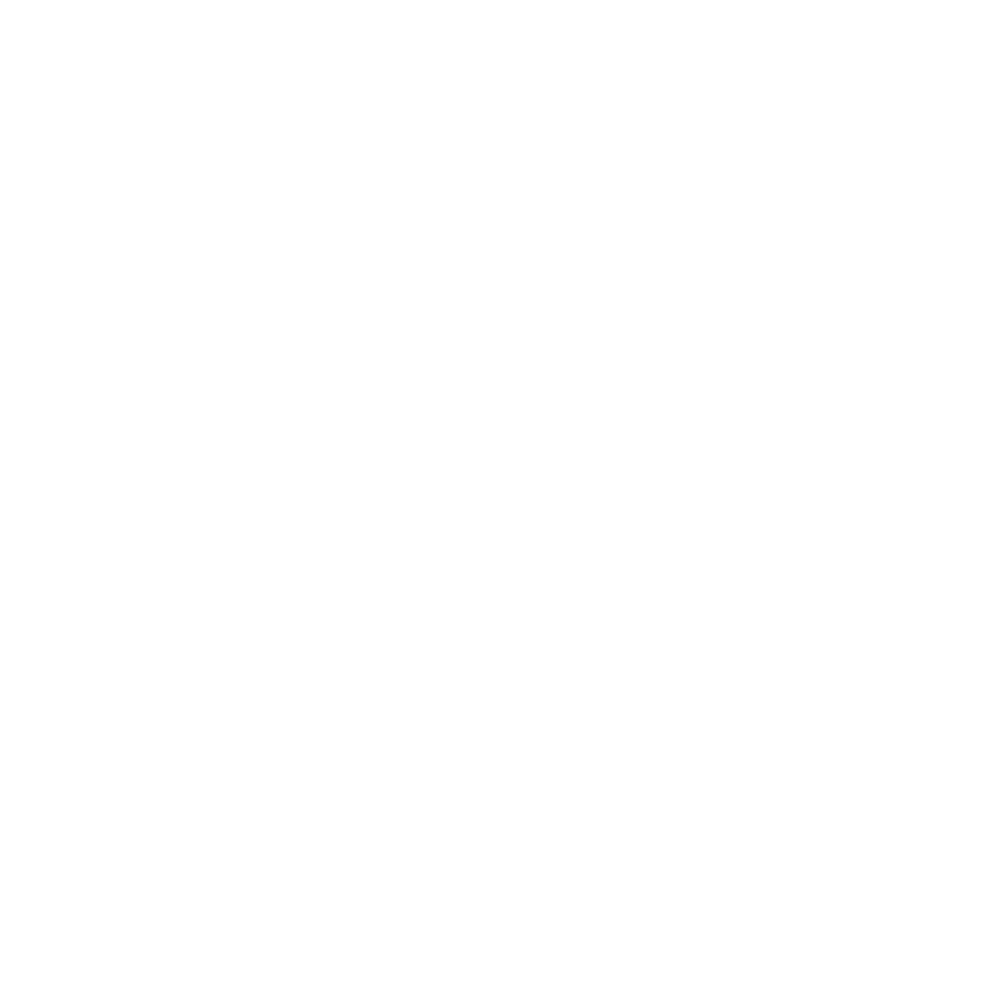

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
normalized_columns = [column for column in errors_test_1.columns if column.startswith('Normalized')]
data = pd.concat([errors_test_1[indices][normalized_columns + ['Anomaly_All', 'log_ft']].reset_index().reset_index(), 
errors_test_1_x[indices][normalized_columns + ['Anomaly_All', 'log_ft']].reset_index().reset_index()], ignore_index=True).rename(
    columns={'index' : 'fake_index'}
).melt(
    ['log_ft', 'Timestamp', 'fake_index', 'Anomaly_All'], var_name='cols', value_name='vals')

ax = sns.lineplot(data=data, x='fake_index', y='vals', hue='cols', style='log_ft')


plt.xticks(range(0, len(data.fake_index.unique()), 72), 
labels = data['Timestamp'].unique()[:-1:72], rotation=320);
plt.grid(False);

plt.axhline(y=1.0)
for index in data[data.Anomaly_All].fake_index:
    plt.axvline(x=index, style='--')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_1 (NBM with log features) and not by model_1_x (NBM without log features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


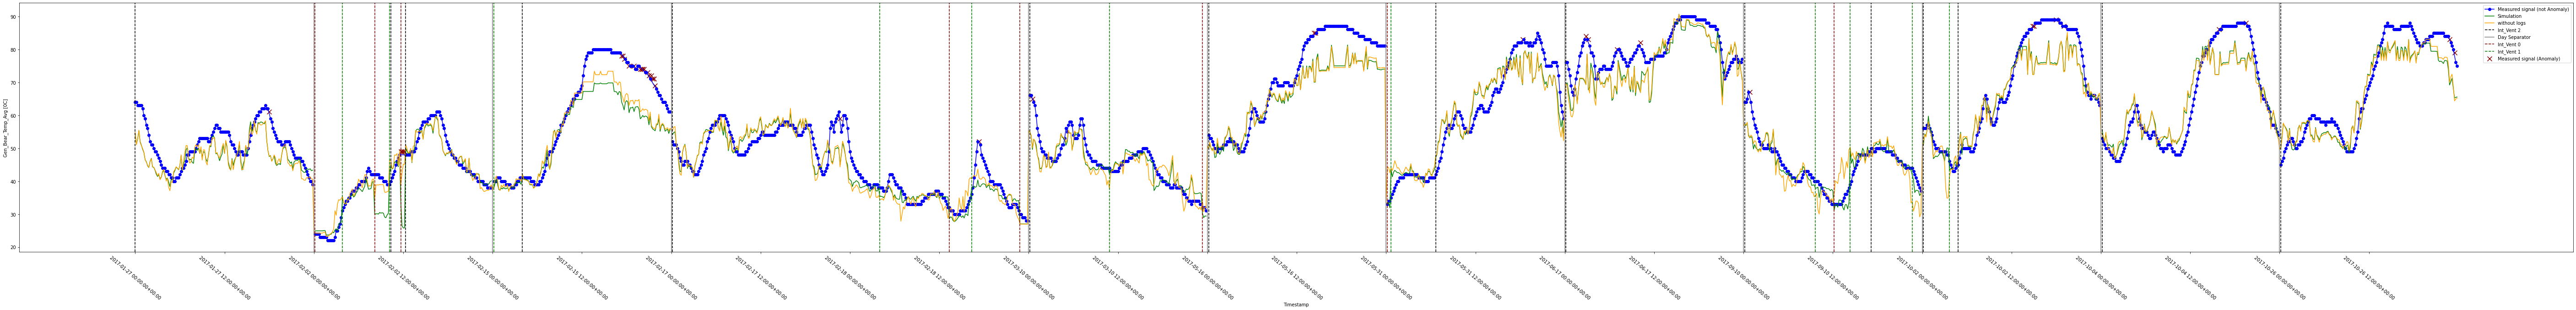

In [ ]:
ixes = (Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))) & ~(Y_test_1.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly']].index.date)))

gt_1 = Y_test_1[ixes].reset_index()
pr_1 = predictions_test_1[ixes].reset_index()
x_1 = X_test_1[ixes].reset_index()

pr_1_x = predictions_test_1_x[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_1, gt_1, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_1_x.index, pr_1_x[target_feature], color='orange', label='without logs')
plot_control_signals(x_1, 'Int_Vent')

plt.xticks(range(0, gt_1.shape[0], 72), labels = gt_1['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_1_x (NBM without log features) and not by model_1 (NBM with log features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


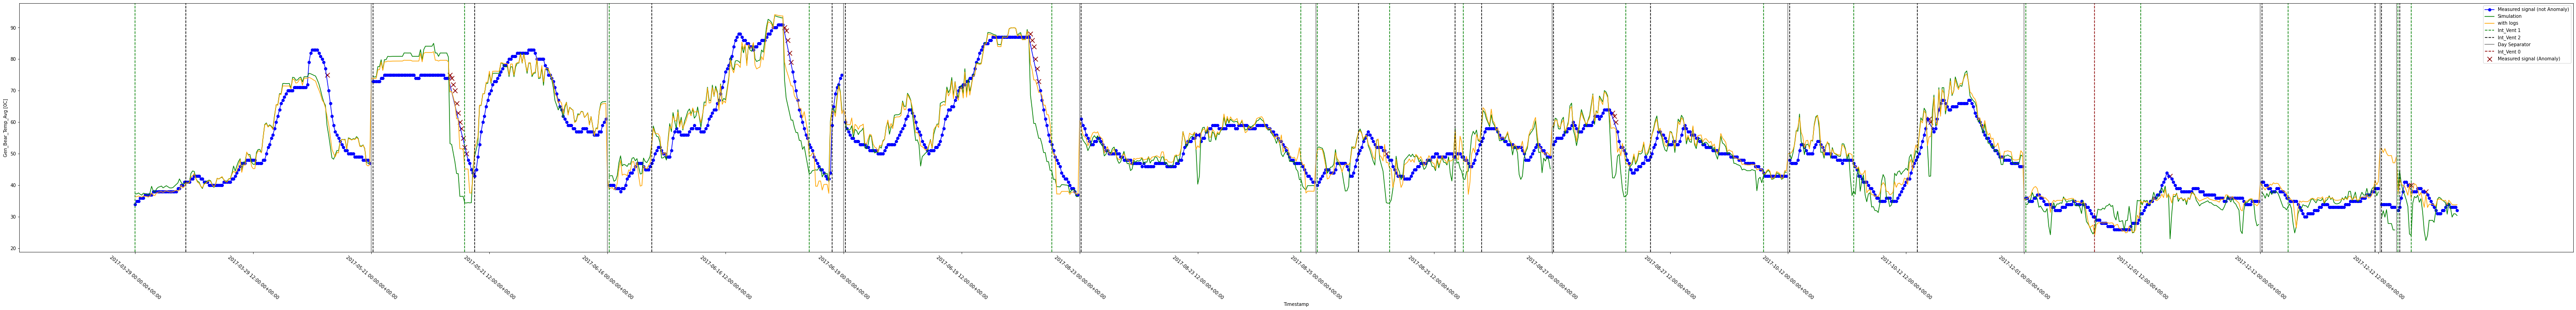

In [ ]:
ixes = (Y_test_1_x.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly']].index.date))) & ~(Y_test_1_x.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date)))

gt_1_x = Y_test_1_x[ixes].reset_index()
pr_1_x = predictions_test_1_x[ixes].reset_index()
x_1_x = X_test_1[ixes].reset_index()

pr_1 = predictions_test_1[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1_x.loc[gt_1_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1_x.loc[gt_1_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1_x.loc[x_1_x['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_1_x, gt_1_x, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_1.index, pr_1[target_feature], color='orange', label='with logs')
plot_control_signals(x_1_x, 'Int_Vent')

plt.xticks(range(0, gt_1_x.shape[0], 72), labels = gt_1_x['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());